**To begin with:**
- In this notebook, I explored and presented measures of feature importance, both data based and model based. 
- **Data based** feature importance method include: Peason rank correlation coefficient, PCA.
- **Model based** feature include: OLS, permutation, drop 
- I also implemented **autoselection of features** to drop those bad ones.
- And I implemented and visualized **mean and variance of feature importance**, as well as **p-value**.
- Note: references are at the bottom of featimp.py

**Dataset:**
- For dataset, I use the sklearn's boston dataset for regression problem but I also tried classification with wine and iris dataset to test if my algorithm work well or not although I didn't include that in this report.

In [24]:
%run featimp

In [2]:
from sklearn.datasets import load_boston

In [3]:
x_reg,y_reg = load_boston().data,load_boston().target

# Feature importance from data

## Pearson rank correlation coefficient

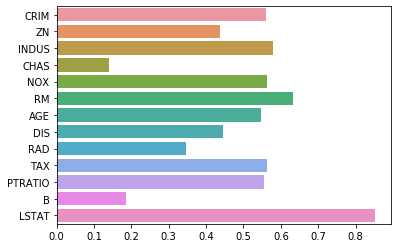

In [82]:
prcc = pearson_rank(x_reg,y_reg)
sns.barplot(x = abs(prcc), y = load_boston().feature_names)
plt.show()

Peason rank correlation coefficient is one of the feature importance that comes directly from data. It measures the correlation of feature with target. It's very handy but not enough to only look at it.

## PCA

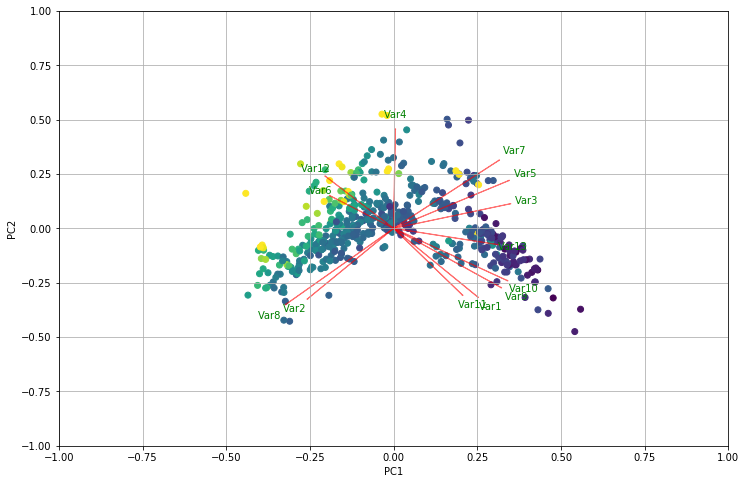

In [5]:
# Standardize
x_transformed = standard_scaler(x_reg)
# PCA
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_transformed)
# Plot
plt.figure(figsize=(12, 8))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
pca_plot(x_pca[:, 0:2], np.transpose(pca.components_[0:2, :]),y_reg)
plt.show()

In [85]:
pca.explained_variance_ratio_

array([0.47129606, 0.11025193, 0.0955859 ])

In [86]:
print(abs( pca.components_ ))

[[0.2509514  0.25631454 0.34667207 0.00504243 0.34285231 0.18924257
  0.3136706  0.32154387 0.31979277 0.33846915 0.20494226 0.20297261
  0.30975984]
 [0.31525237 0.3233129  0.11249291 0.45482914 0.21911553 0.14933154
  0.31197778 0.34907    0.27152094 0.23945365 0.30589695 0.23855944
  0.07432203]
 [0.24656649 0.29585782 0.01594592 0.28978082 0.12096411 0.59396117
  0.01767481 0.04973627 0.28725483 0.22074447 0.32344627 0.3001459
  0.26700025]]


- PCA is usually the way to decomposition data and extract the main components. Here I set conponents to 3.
- To generate feature importance value from PCA, we look at how much the biggest component explains total variance and how is every feature relate to that component. 
- Here, the biggest component expalins 47.1% of total variance, which is not very big, indicating the feature importance may not be quite reliable. Usually the bigger the variance explained, the more reliable PCA feature imporatnce is.
- Here the rows of pca.components_ means components and columns mean feature.

# Model based feature importance

## OLS

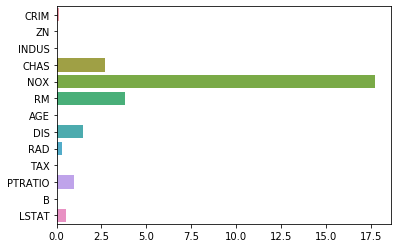

In [84]:
ols_coef = ols_featimp(x_reg,y_reg)
sns.barplot(x = abs(ols_coef), y = load_boston().feature_names)
plt.show()

Feature importance derived from OLS is a way to reflect how features are linearly related to target, so although it is model based, it's not a very reliable way, because feature can also be related to target in ways other than linear.

## Prepare data and model

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [9]:
df_x_reg = pd.DataFrame(data=x_reg,
                       columns=load_boston().feature_names)
df_y_reg = pd.DataFrame(data=y_reg,
                       columns=['target'])

In [10]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    df_x_reg, df_y_reg, test_size=0.3, random_state=0)

In [66]:
rf_reg = RandomForestRegressor(max_depth=15,min_samples_leaf=1,oob_score = True)
rf_reg.fit(x_train_reg,y_train_reg["target"].values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

Permutation and drop column importance are reliable ways of measuring feature importance. Permutation shuffules one single feature randomly so it cut the relation of it with other features and target and compare performance to full model. Compared to drop column, it doesn't need to fit model a lot of times so is fast. Drop column feature importance drop one feature at a time to test how the model performs compared to baseline. It is ground truth but requires long time especially when dataset is large and features are a lot.

## Permutation

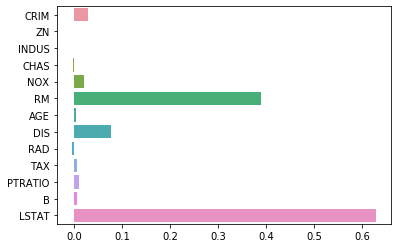

In [25]:
permutation_imp = permutation_importances(rf_reg, x_test_reg, y_test_reg, metrics.r2_score)
sns.barplot(x = permutation_imp, y = load_boston().feature_names)
plt.show()

## Drop column importance

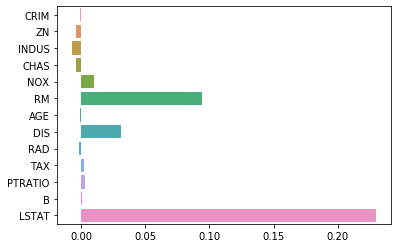

In [94]:
dropc_col_imp = dropcol_importances(rf_reg, x_train_reg, y_train_reg["target"].values, x_test_reg, y_test_reg["target"].values, metrics.r2_score)
sns.barplot(x = dropc_col_imp, y = load_boston().feature_names)
plt.show()

# Compare strategies

## Shap

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


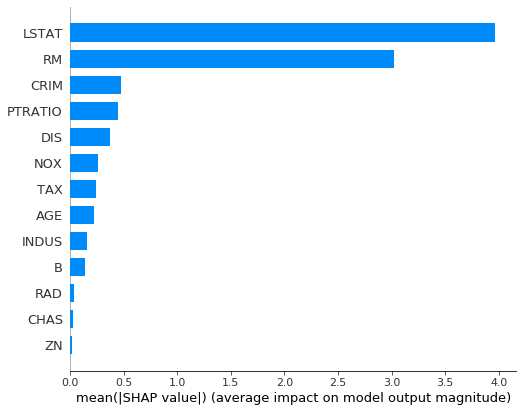

In [23]:
shap_values = get_shap_values(rf_reg, x_reg, load_boston().feature_names)

SHAP is also a reliable way of measuring feature importance.

## Compare strategies

In [106]:
ols_new = (ols_coef - np.min(ols_coef))/(np.max(ols_coef) - np.min(ols_coef))

In [107]:
df_imp = pd.DataFrame(data = {"feature_names":load_boston().feature_names,
                              "corr_imp":abs(prcc),
                              "pca_imp":pca.components_[0],
                              "ols_imp":abs(ols_new),
                              "permutation":permutation_imp,
                              "drop_column":dropc_col_imp})
df_imp

,feature_names,corr_imp,pca_imp,ols_imp,permutation,drop_column
0,CRIM,0.558891,0.250951,0.818419,0.029856,-0.000934
1,ZN,0.438179,-0.256315,0.825576,-0.000471,-0.003789
2,INDUS,0.578255,0.346672,0.824378,0.000194,-0.007404
3,CHAS,0.140612,0.005042,0.947946,-0.001244,-0.003850
4,NOX,0.562609,0.342852,0.000000,0.020775,0.010004
5,RM,0.633576,-0.189243,1.000000,0.388772,0.094452
6,AGE,0.547562,0.313671,0.823457,0.004516,-0.001190
7,DIS,0.445857,-0.321544,0.755037,0.077301,0.031279
8,RAD,0.346776,0.319793,0.837609,-0.004471,-0.001933
9,TAX,0.562411,0.338469,0.822853,0.006420,0.002028


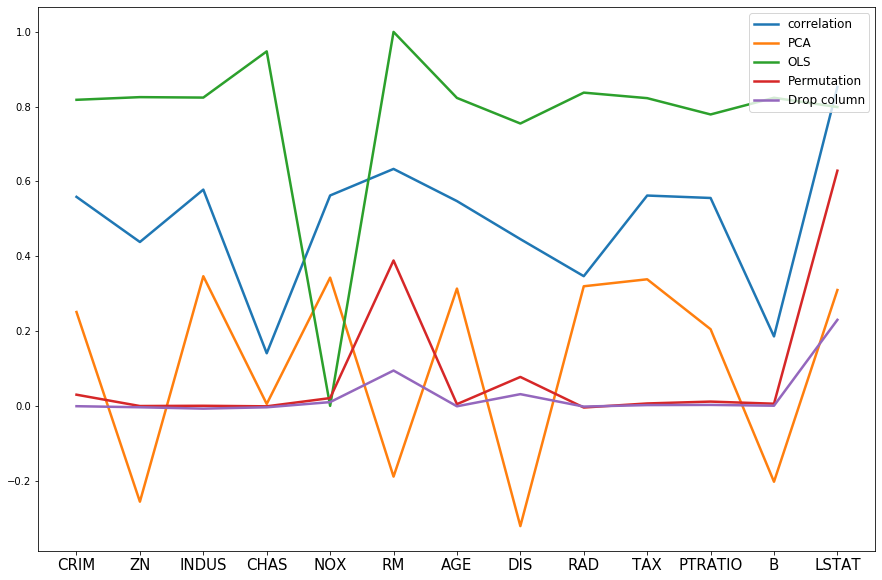

In [140]:
labels = ['correlation','PCA', 'OLS', 'Permutation', 'Drop column']
plt.figure(figsize=(15, 10))
plt.xticks(np.arange(0, len(load_boston().feature_names)+1),
           load_boston().feature_names, size=15)
plt.plot(df_imp[['corr_imp', 'pca_imp', 'ols_imp', 'permutation', 'drop_column']],
         linewidth=2.5)
plt.legend(labels, loc = 1, fontsize = 'large')
plt.show()

- Permutation and drop column importance are similar according to result. They have the same trend but only differs on the feature that have high importance.
- Coorelation and PCA are quite similar.
- OLS turns out not to be a good option.

# Automatic feature selection algorithm

Automatic feature selection is to drop the most bad-behaved features according to feature importance. Here I use drop column feature importance as a standard. So for every iteration, I drop the feature with lowest feature importance, and fit the model to see how the r2 goes. I stop when validation goes bad, return the best model and plot its feature importance.

Base line is:0.8232318940881481
----------------Round0---------------------
Begining feature nameIndex(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
Dropped feature name:CHAS
Score:0.8306359183986158
----------------Round1---------------------
Begining feature nameIndex(['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
Dropped feature name:NOX
Score:0.8280316870825899
---------------- Final  ---------------------
Finally we drop:['CHAS']
Final score is:0.8270815818586285


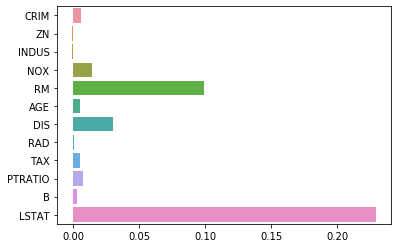

In [81]:
final_model = auto_selection(rf_reg, x_train_reg, y_train_reg["target"].values, x_test_reg, y_test_reg["target"].values, metrics.r2_score)

# Mean, variance and empirical p-values

## Mean and variance

The purpose of measuring mean and variance of feature importance is too see how it will change according to data. So what I did here is bootstrapped test data and see how the feature importance changes with different dataset. For this dataset the variance is small, but when I tested on wine data set for classification problem, the variance is really big, for some feature it even matches the feature importance itself.

In [45]:
rf_reg = RandomForestRegressor(max_depth=15,min_samples_leaf=1,oob_score = True)
rf_reg.fit(x_train_reg,y_train_reg["target"].values)
imp_distribution = mean_variance(rf_reg, df_x_reg, df_y_reg, metrics.r2_score,100)
mean_ = np.mean(imp_distribution,axis = 0)
var_ = np.var(imp_distribution,axis = 0)

In [46]:
sorted_mean_, sorted_var_,sorted_names = zip(*sorted(zip(mean_, var_,load_boston().feature_names),reverse = True))

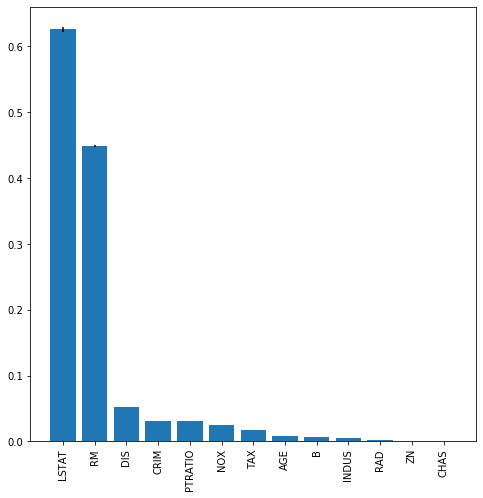

In [47]:
plt.figure(figsize=(8,8))
plt.bar(sorted_names, sorted_mean_, yerr = sorted_var_)
plt.xticks(rotation = 90)
plt.show()

## Empirical p-values

The way to get p-values of feature importance is to shuffle y randomly, get simulation of distribution and see at what position are our real feature importance in the distrubution. If it's at the tail, then it means that the chances of this feature importance gernerated randomly is small.

In [77]:
p_values = p_value(rf_reg, x_test_reg, y_test_reg, metrics.r2_score, 100)
real = p_values[0,:]
fake = p_values[1:,:]

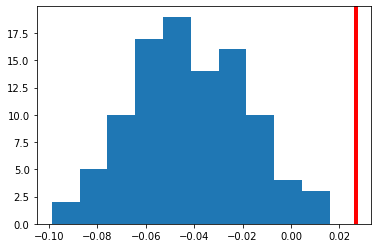

In [78]:
# CRIM
plt.hist(fake[:,0])
plt.axvline(x = real[0],linewidth=4, color='r')
plt.show()

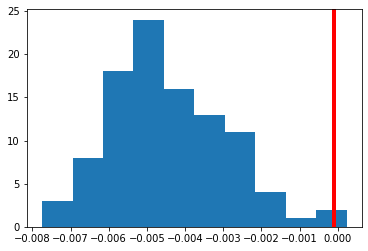

In [79]:
# ZN
plt.hist(fake[:,1])
plt.axvline(x = real[1],linewidth=4, color='r')
plt.show()